In [1]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [2]:
# Read in the data
(x_train, y_train), (x_test, y_test) = mnist.load_data()

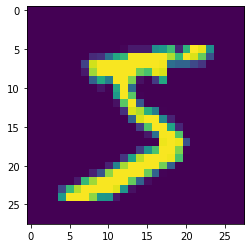

In [3]:
plt.imshow(x_train[0])

In [4]:
# Prepare one-hot encoded y-values
y_train_cat = to_categorical(y=y_train, num_classes=10)
y_test_cat = to_categorical(y=y_test, num_classes=10)

In [5]:
# Normalize image pixel values
x_train = x_train / 255
x_test = x_test / 255

In [6]:
print(x_train.shape)
print(x_test.shape)

(60000, 28, 28)
(10000, 28, 28)


In [7]:
# Reshaping data to batch_size, width, height, color_channel
x_train = x_train.reshape(60000, 28, 28, 1)
x_test = x_test.reshape(10000, 28, 28, 1)

In [8]:
# Prepare GPU
def prep_gpu():
    phy_gpus = tf.config.list_physical_devices(device_type='GPU')

    for gpu in phy_gpus:
        tf.config.experimental.set_memory_growth(device=gpu, enable=True)

    log_gpus = tf.config.list_logical_devices(device_type='GPU')
    phy_cpus = tf.config.list_physical_devices(device_type='CPU')
    log_cpus = tf.config.list_logical_devices(device_type='CPU')

    print("Physical GPUs: {}\tLogical GPUs: {}\nPhysical CPUs: {}\tLogical CPUs: {}".format(len(phy_gpus),
                                                                                             len(log_gpus),
                                                                                             len(phy_cpus),
                                                                                             len(log_cpus)))

In [9]:
prep_gpu()

Physical GPUs: 1	Logical GPUs: 1
Physical CPUs: 1	Logical CPUs: 1


2021-09-25 04:18:04.445678: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-09-25 04:18:04.445968: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libamdhip64.so
2021-09-25 04:18:04.486332: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1734] Found device 0 with properties: 
pciBusID: 0000:06:00.0 name: Ellesmere [Radeon RX 470/480/570/570X/580/580X/590]     ROCm AMDGPU Arch: gfx803
coreClock: 1.411GHz coreCount: 36 deviceMemorySize: 8.00GiB deviceMemoryBandwidth: 119.21GiB/s
2021-09-25 04:18:04.488893: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library librocblas.so
2021-09-25 04:18:04.490852: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libMIOpen.so
2021-09-25 04:18:04.510831: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dyn

In [10]:
# Build model
backend.clear_session()
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(4, 4), input_shape=(28, 28, 1), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(10, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

# Create early stopping callback
early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=1)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 25, 25, 32)        544       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 4608)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               589952    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1290      
Total params: 591,786
Trainable params: 591,786
Non-trainable params: 0
_________________________________________________________________


In [11]:
# Train model with force_CPU
with tf.device(device_name='/device:cpu:0'):
    model.fit(x=x_train, y=y_train_cat, epochs=10, validation_data=(x_test, y_test_cat), callbacks=[early_stop], verbose=1)

2021-09-25 04:18:17.092919: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-09-25 04:18:17.111727: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3400125000 Hz


Epoch 1/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.2802 - accuracy: 0.9184 - val_loss: 0.0504 - val_accuracy: 0.9841
Epoch 2/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0465 - accuracy: 0.9856 - val_loss: 0.0453 - val_accuracy: 0.9852
Epoch 3/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0276 - accuracy: 0.9915 - val_loss: 0.0463 - val_accuracy: 0.9847


In [12]:
# Model evaluation
metrics = pd.DataFrame(model.history.history)

In [13]:
metrics

,loss,accuracy,val_loss,val_accuracy
0,0.137524,0.960217,0.050384,0.9841
1,0.047341,0.985367,0.045329,0.9852
2,0.029341,0.990650,0.046278,0.9847


<AxesSubplot:>

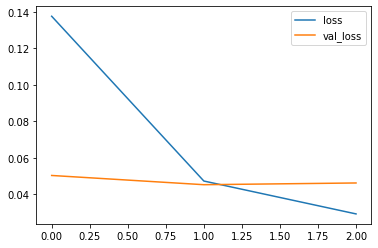

In [14]:
metrics[['loss', 'val_loss']].plot()

<AxesSubplot:>

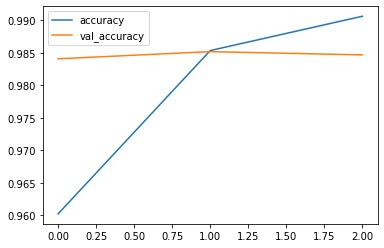

In [15]:
metrics[['accuracy', 'val_accuracy']].plot()

In [16]:
with tf.device(device_name='/device:cpu:0'):
    model.evaluate(x_train, y_train_cat)

1875/1875 [==============================] - 5s 3ms/step - loss: 0.0263 - accuracy: 0.9918


In [ ]:
# Make predictions and see classification report
y_pred = np.argmax(model.predict(x_test), axis=-1)

2021-09-25 04:19:39.731735: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library librocblas.so
2021-09-25 04:19:39.746864: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libMIOpen.so
MIOpen(HIP): Error [ValidateGcnAssemblerImpl] Wrong path to assembler: '/opt/rocm-4.3.0/llvm/bin/clang'. Expect performance degradation.


In [18]:
print(classification_report(y_true=np.array(y_test), y_pred=y_pred))
print("\n")
print(confusion_matrix(y_true=np.array(y_test), y_pred=y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       980
           1       0.99      1.00      0.99      1135
           2       0.99      0.98      0.99      1032
           3       0.98      0.99      0.98      1010
           4       0.98      1.00      0.99       982
           5       0.99      0.98      0.99       892
           6       0.99      0.99      0.99       958
           7       0.99      0.98      0.99      1028
           8       0.98      0.98      0.98       974
           9       0.99      0.97      0.98      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



[[ 976    0    0    1    0    0    2    0    1    0]
 [   0 1132    1    1    0    0    1    0    0    0]
 [   1    3 1014    4    1    0    2    3    4    0]
 [   0    0    1 1002    0    3    0    0    4    0]
 [   0    0    0    0  979 

In [19]:
# Train model with force_GPU
with tf.device(device_name='/device:gpu:0'):
    model.fit(x=x_train, y=y_train_cat, epochs=10, validation_data=(x_test, y_test_cat), callbacks=[early_stop], verbose=1)

Epoch 1/10
1875/1875 [==============================] - 9s 5ms/step - accuracy: 0.9926 - loss: 0.0231 - val_accuracy: 0.9873 - val_loss: 0.0365
Epoch 2/10
1875/1875 [==============================] - 9s 5ms/step - accuracy: 0.9948 - loss: 0.0158 - val_accuracy: 0.9873 - val_loss: 0.0400


<AxesSubplot:>

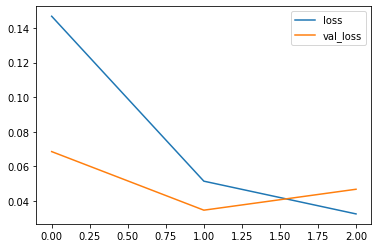

In [20]:
metrics[['loss', 'val_loss']].plot()

<AxesSubplot:>

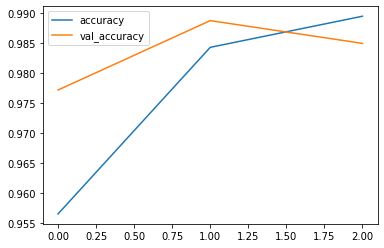

In [21]:
metrics[['accuracy', 'val_accuracy']].plot()

In [22]:
with tf.device(device_name='/device:gpu:0'):
    model.evaluate(x_train, y_train_cat)

1875/1875 [==============================] - 7s 4ms/step - accuracy: 0.9957 - loss: 0.0123


In [23]:
# Make predictions and see classification report
y_pred = np.argmax(model.predict(x_test), axis=-1)

In [24]:
print(classification_report(y_true=np.array(y_test), y_pred=y_pred))
print("\n")
print(confusion_matrix(y_true=np.array(y_test), y_pred=y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       980
           1       1.00      0.99      1.00      1135
           2       0.99      0.99      0.99      1032
           3       0.99      0.99      0.99      1010
           4       1.00      0.97      0.98       982
           5       0.99      0.98      0.99       892
           6       0.99      0.99      0.99       958
           7       0.99      0.99      0.99      1028
           8       0.98      0.99      0.98       974
           9       0.96      0.99      0.97      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



[[ 978    0    0    0    0    0    0    0    1    1]
 [   0 1127    1    2    0    0    3    1    1    0]
 [   3    0 1017    1    0    0    0    3    8    0]
 [   0    0    0 1004    0    3    0    0    2    1]
 [   1    0    5    0  949 